<a href="https://colab.research.google.com/github/gloriapintado/Cervical-Cancer-Prediction/blob/main/Cervical_Cancer_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling with VGG16

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image, ImageOps
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Lambda, Dense
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
image_directory = '/content/drive/MyDrive/Cervical Cancer/'
SIZE = 150

dataset = []
label = []

# For each class, load images and assign labels
class_folders = ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']

for class_folder in class_folders:
    images = os.listdir(image_directory + class_folder + '/')
    for image_name in images:
        if image_name.split('.')[1] == 'jpg':
            image = cv2.imread(image_directory + class_folder + '/' + image_name)
            image = Image.fromarray(image, 'RGB')
            image = image.resize((SIZE, SIZE))
            dataset.append(np.array(image))

            label.append(class_folders.index(class_folder))

dataset = np.array(dataset)
label = np.array(label)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 42)

In [5]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20000, 150, 150, 3)
X_test shape: (5000, 150, 150, 3)
y_train shape: (20000,)
y_test shape: (5000,)


# Pretrained VGG16 Model

In [6]:
VGG16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [7]:
VGG16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

###  My classifier

In [8]:
vgg16_model = Sequential()
vgg16_model.add(VGG16_base)
vgg16_model.add(Lambda(lambda x: x / 255.0))
vgg16_model.add(Flatten())
vgg16_model.add(Dense(256, activation='relu'))
vgg16_model.add(Dense(5, activation='softmax'))

In [9]:
VGG16_base.trainable = False

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
vgg16_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizers.RMSprop(learning_rate=2e-5),
                 metrics=['accuracy'])

In [11]:
history_vgg16_model = vgg16_model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), callbacks=[early_stopping], batch_size=32)

Epoch 1/15
625/625 [==============================] - 27s 28ms/step - loss: 1.3463 - accuracy: 0.6848 - val_loss: 1.0927 - val_accuracy: 0.8150
Epoch 2/15
625/625 [==============================] - 16s 26ms/step - loss: 0.9281 - accuracy: 0.8395 - val_loss: 0.7962 - val_accuracy: 0.8472
Epoch 3/15
625/625 [==============================] - 16s 26ms/step - loss: 0.7062 - accuracy: 0.8649 - val_loss: 0.6325 - val_accuracy: 0.8668
Epoch 4/15
625/625 [==============================] - 16s 26ms/step - loss: 0.5748 - accuracy: 0.8813 - val_loss: 0.5289 - val_accuracy: 0.8804
Epoch 5/15
625/625 [==============================] - 16s 26ms/step - loss: 0.4870 - accuracy: 0.8928 - val_loss: 0.4570 - val_accuracy: 0.8940
Epoch 6/15
625/625 [==============================] - 16s 26ms/step - loss: 0.4236 - accuracy: 0.9036 - val_loss: 0.4043 - val_accuracy: 0.9042
Epoch 7/15
625/625 [==============================] - 16s 26ms/step - loss: 0.3749 - accuracy: 0.9139 - val_loss: 0.3622 - val_accuracy:

In [12]:
evaluation = vgg16_model.evaluate(X_test, y_test)

157/157 [==============================] - 3s 21ms/step - loss: 0.1940 - accuracy: 0.9550


In [13]:
predictions = vgg16_model.predict(X_test)

157/157 [==============================] - 3s 20ms/step


In [15]:
y_pred = np.argmax(predictions, axis=1)

In [16]:
class_names = ['Dyskeratotic','Koilocytotic','Metaplastic','Parabasal','Superficial-Intermediat']

In [17]:
print(classification_report(y_test, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

           Dyskeratotic       0.94      0.96      0.95      1021
           Koilocytotic       0.96      0.89      0.92      1000
            Metaplastic       0.95      0.95      0.95       985
              Parabasal       0.98      0.99      0.99       989
Superficial-Intermediat       0.95      0.97      0.96      1005

               accuracy                           0.95      5000
              macro avg       0.96      0.96      0.95      5000
           weighted avg       0.96      0.95      0.95      5000



# Unfreezing last block of VGG16 Base

In [18]:
VGG16_base.trainable = True

In [19]:
for layer in VGG16_base.layers:
    if layer.name in ['block1_conv1', 'block1_conv2']:
        layer.trainable = True
    else:
        layer.trainable = False

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
vgg16_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizers.RMSprop(learning_rate=2e-5),
                 metrics=['accuracy'])

In [21]:
history_vgg16_model_fine = vgg16_model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), callbacks=[early_stopping], batch_size=32)

Epoch 1/15
625/625 [==============================] - 37s 54ms/step - loss: 0.1397 - accuracy: 0.9646 - val_loss: 0.1396 - val_accuracy: 0.9622
Epoch 2/15
625/625 [==============================] - 33s 53ms/step - loss: 0.1113 - accuracy: 0.9714 - val_loss: 0.1190 - val_accuracy: 0.9678
Epoch 3/15
625/625 [==============================] - 33s 53ms/step - loss: 0.0936 - accuracy: 0.9750 - val_loss: 0.1047 - val_accuracy: 0.9702
Epoch 4/15
625/625 [==============================] - 33s 53ms/step - loss: 0.0805 - accuracy: 0.9803 - val_loss: 0.0930 - val_accuracy: 0.9734
Epoch 5/15
625/625 [==============================] - 33s 53ms/step - loss: 0.0697 - accuracy: 0.9833 - val_loss: 0.0822 - val_accuracy: 0.9772
Epoch 6/15
625/625 [==============================] - 33s 53ms/step - loss: 0.0608 - accuracy: 0.9858 - val_loss: 0.0745 - val_accuracy: 0.9784
Epoch 7/15
625/625 [==============================] - 33s 53ms/step - loss: 0.0534 - accuracy: 0.9883 - val_loss: 0.0665 - val_accuracy:

In [23]:
vgg16_model_save_name = 'vgg16_model.h5'
vgg16_model.save(vgg16_model_save_name)

drive_path = "/content/drive/MyDrive/Cervical_Cancer_Models/models/"

vgg16_model_save_save_path = os.path.join(drive_path, vgg16_model_save_name)
vgg16_model.save(vgg16_model_save_save_path)

In [24]:
predictions2 = vgg16_model.predict(X_test)

157/157 [==============================] - 3s 20ms/step


In [25]:
y_pred2 = np.argmax(predictions2, axis=1)

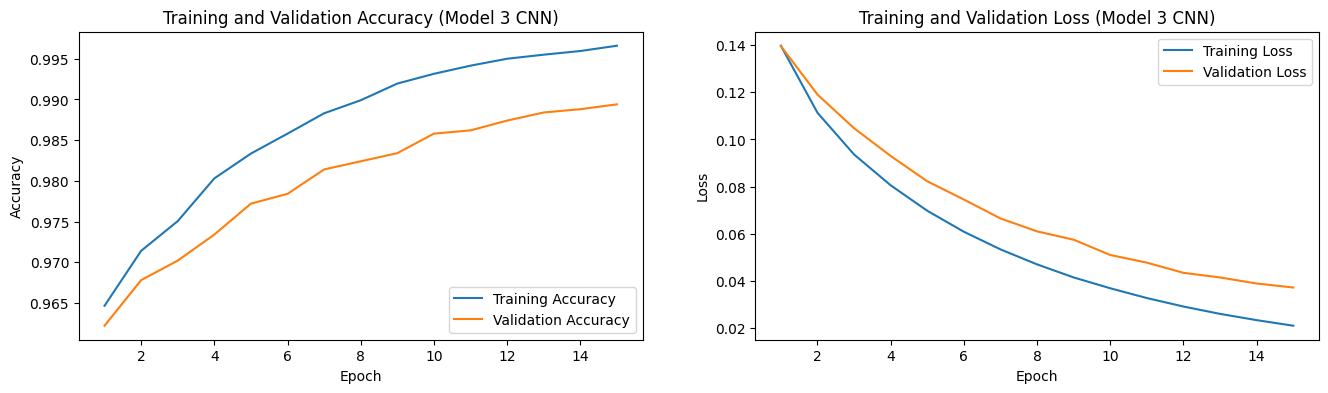

In [28]:
acc = history_vgg16_model_fine.history['accuracy']
val_acc = history_vgg16_model_fine.history['val_accuracy']
loss = history_vgg16_model_fine.history['loss']
val_loss = history_vgg16_model_fine.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Model 3 CNN)')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Model 3 CNN)')
plt.show()

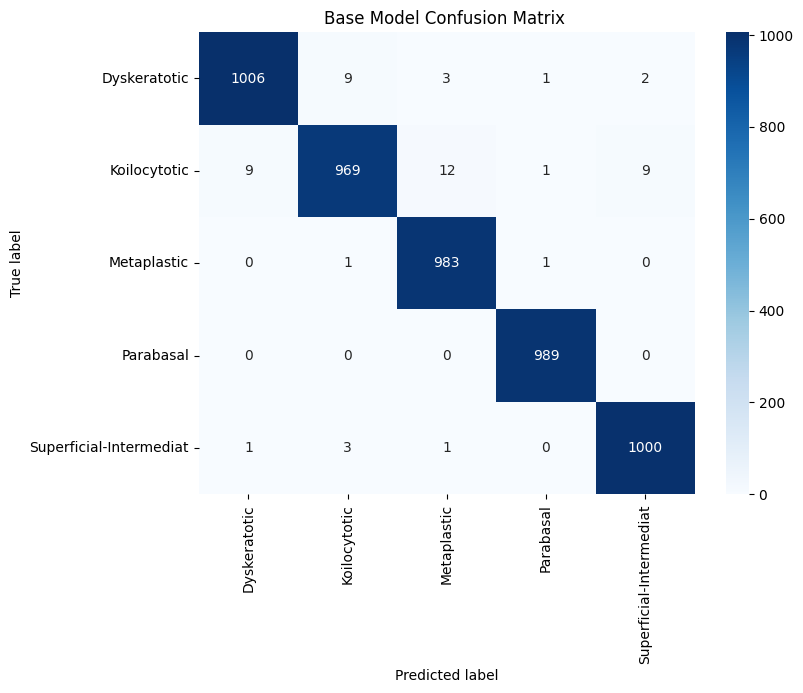

In [31]:
class_names = ['Dyskeratotic','Koilocytotic','Metaplastic','Parabasal','Superficial-Intermediat']

# Compute confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Base Model Confusion Matrix ')
plt.show()

In [32]:
print(classification_report(y_test, y_pred2, target_names=class_names))

                         precision    recall  f1-score   support

           Dyskeratotic       0.99      0.99      0.99      1021
           Koilocytotic       0.99      0.97      0.98      1000
            Metaplastic       0.98      1.00      0.99       985
              Parabasal       1.00      1.00      1.00       989
Superficial-Intermediat       0.99      1.00      0.99      1005

               accuracy                           0.99      5000
              macro avg       0.99      0.99      0.99      5000
           weighted avg       0.99      0.99      0.99      5000

